In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

In [6]:
def get_data(filename: str, x_axis, y_axis):
    arr_size = []
    arr_bw = []
    with open(filename, "r") as f:
        for row in f:
            tokens = row.split()
            arr_size.append(float(tokens[x_axis].split(")")[0]))
            arr_bw.append(float(tokens[y_axis]))
    

    return (arr_size, arr_bw)

In [9]:
max_bandwidth = 366 # GBPS

L1cache = 32768 * 30 # bytes
L2cache = 3145728 # bytes
L2cummulative = L1cache + L2cache # bytes

N_L1cache= 990 # N^2 + N + N = L1cache / 4 (bytes/num)
N_L2cache = 2031 # N^2 + N + N = L2cummulative

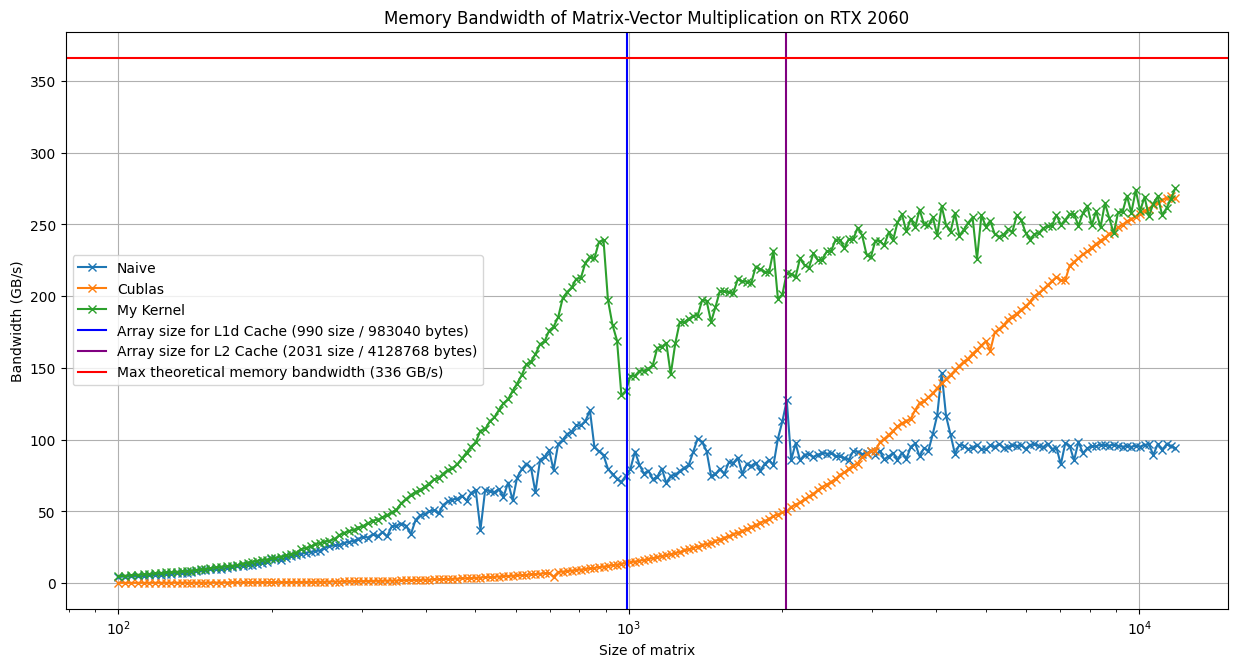

In [13]:
naive1x, naive1y = get_data("data/task1_naive.txt", 6, -2)
cublas1x, cublas1y = get_data("data/task2_1_cublas.txt", 6, -2)
matvecmul1x, matvecmul1y = get_data("data/task1_mykernel.txt", 6, -2)

plt.figure(figsize=(15, 7.5))
plt.plot(naive1x, naive1y, "x-", label="Naive")
plt.plot(cublas1x, cublas1y, "x-", label="Cublas")
plt.plot(matvecmul1x, matvecmul1y, "x-", label="My Kernel")
plt.axvline(x=N_L1cache, label=f"Array size for L1d Cache ({N_L1cache} size / {L1cache} bytes)", color="b")
plt.axvline(x=N_L2cache, label=f"Array size for L2 Cache ({N_L2cache} size / {L2cummulative} bytes)", color="purple")
plt.axhline(max_bandwidth, label=f"Max theoretical memory bandwidth (336 GB/s)", color="red")
# plt.axvline(x=l2_size_amd, label=f"L2 Cache ({l2_size_amd} elements)", color="orange")
# plt.axvline(x=l3_size_amd, label=f"L3 Cache ({l3_size_amd} elements)", color="purple")
plt.xlabel("Size of matrix")
plt.ylabel("Bandwidth (GB/s)")
plt.legend()
plt.xscale("log")
plt.grid("both")
plt.title("Memory Bandwidth of Matrix-Vector Multiplication on RTX 2060")
plt.show()

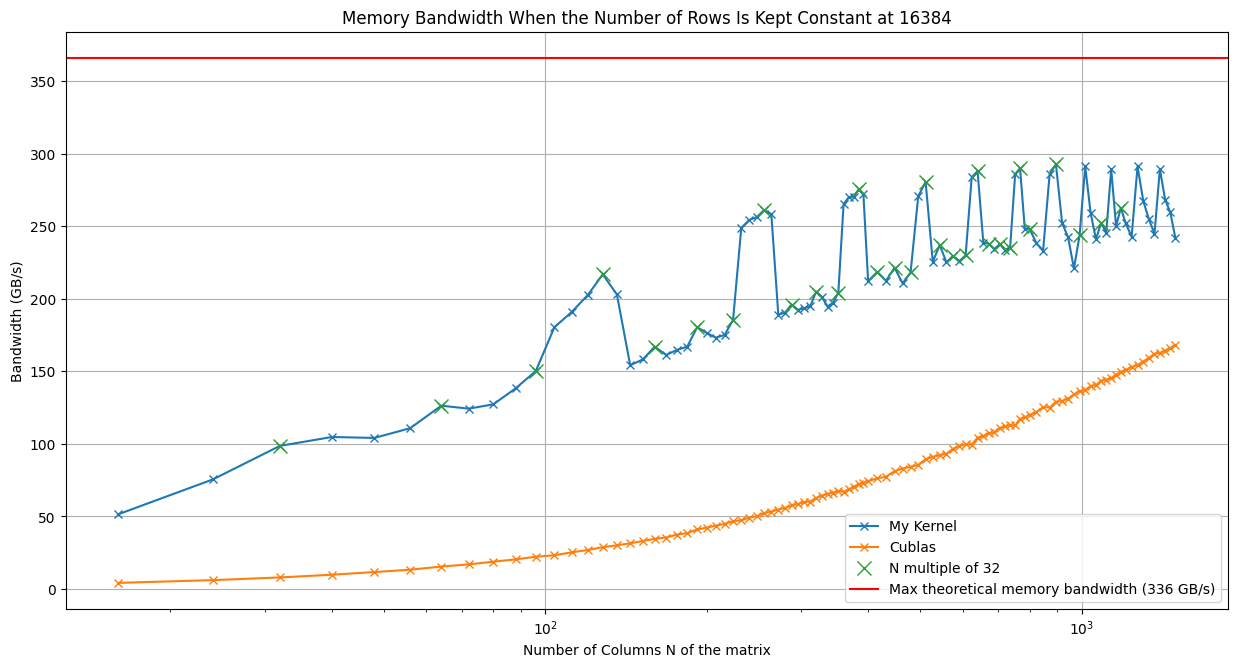

In [33]:
N_L1cache_constrow = 14 # 16384 * N + N + 16384 = L1cache / 4
N_L2cache_constrow = 62 # 16384 * N + N + 16384 = L2cummulative / 4

mykernel_constrow_x, mykernel_constrow_y = get_data("data/task2_3_mykernel.txt", 8, -2)
cublas_constrow_x, cublas_constrow_y = get_data("data/task2_3_cublas.txt", 8, -2)

x32 = []
y32 = []
for i, x in enumerate(mykernel_constrow_x):
    if x % 32 == 0:
        y32.append(mykernel_constrow_y[i])
        x32.append(x)

plt.figure(figsize=(15, 7.5))
plt.plot(mykernel_constrow_x, mykernel_constrow_y, "x-", label="My Kernel")
plt.plot(cublas_constrow_x, cublas_constrow_y, "x-", label="Cublas")
plt.plot(x32, y32, "x", markersize=10, label="N multiple of 32")
plt.axhline(max_bandwidth, label=f"Max theoretical memory bandwidth (336 GB/s)", color="red")
# plt.axvline(x=N_L1cache_constrow, label=f"Array size for L1d Cache (N: {N_L1cache_constrow})", color="b")
# plt.axvline(x=N_L2cache_constrow, label=f"Array size for L2 Cache (N: {N_L2cache_constrow})", color="purple")
# plt.axvline(x=l2_size_amd, label=f"L2 Cache ({l2_size_amd} elements)", color="orange")
# plt.axvline(x=l3_size_amd, label=f"L3 Cache ({l3_size_amd} elements)", color="purple")
plt.xlabel("Number of Columns N of the matrix")
plt.ylabel("Bandwidth (GB/s)")
plt.legend()
plt.xscale("log")
plt.grid("both")
plt.title("Memory Bandwidth When the Number of Rows Is Kept Constant at 16384")
plt.show()

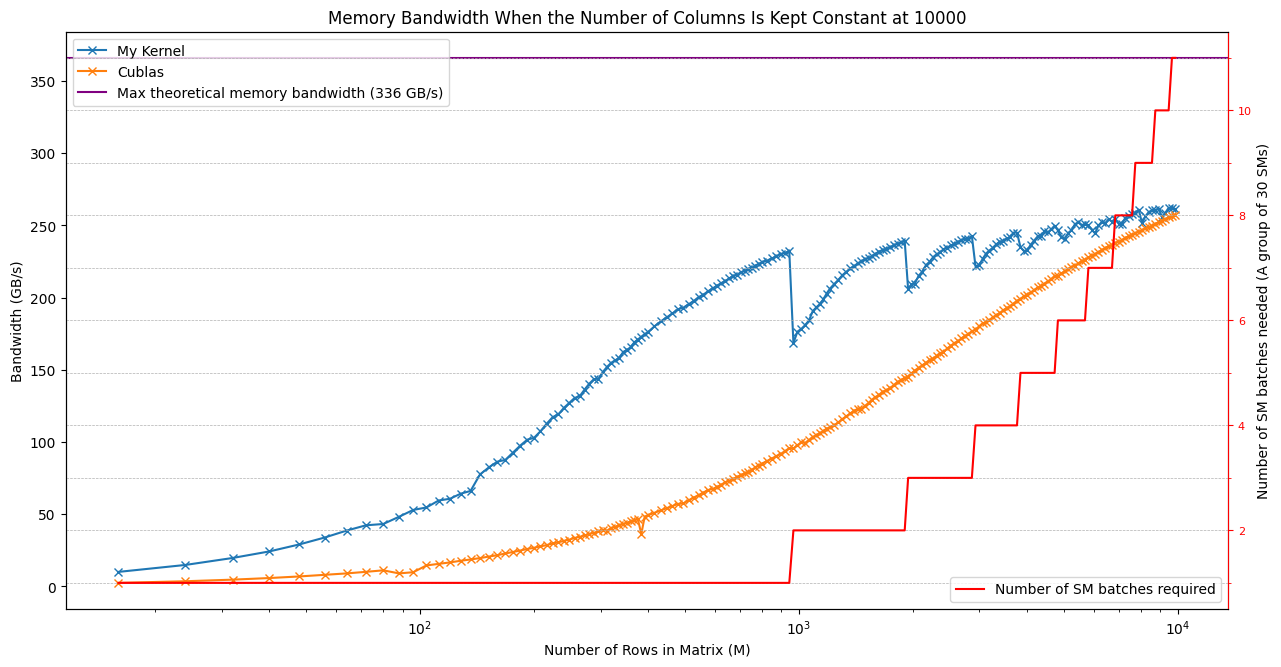

In [30]:
N_L1cache_constrow = 14 # 1000 * N + 1000 + N = L1cache / 4
N_L2cache_constrow = 62 # 1000 * N + 1000 + N = L2cummulative / 4

mykernel_constcol_x, mykernel_constcol_y = get_data("data/task2_2_mykernel.txt", 6, -2)
cublas_constcol_x, cublas_constcol_y = get_data("data/task2_2_cublas.txt", 6, -2)

N_SM_Steps_list = []
for i in mykernel_constcol_x:
    n_blocks = np.floor((i + 32 - 1) / 32) + 0.00001
    n_SM_steps = np.ceil((n_blocks-1) / 30)# 30 SMs
    N_SM_Steps_list.append(n_SM_steps)
    # print(n_blocks, n_SM_steps)

fig, ax1 = plt.subplots(figsize = (15, 7.5))
ax1.plot(mykernel_constcol_x, mykernel_constcol_y, "x-", label="My Kernel")
ax1.plot(cublas_constcol_x, cublas_constcol_y, "x-", label="Cublas")
ll = 230

ax2 = ax1.twinx()

ax2.plot(mykernel_constcol_x[:ll], N_SM_Steps_list[:ll], label="Number of SM batches required", color="red")
ax2.tick_params(axis='y', which='both', labelsize=8, colors='red')
ax1.set_xlabel("Number of Rows in Matrix (M)")
ax2.set_ylabel("Number of SM batches needed (A group of 30 SMs)")
ax1.axhline(max_bandwidth, label=f"Max theoretical memory bandwidth (336 GB/s)", color="purple")
ax1.set_ylabel("Bandwidth (GB/s)")
ax1.set_xticks([1000])
ax1.legend(loc="upper left")
ax2.legend(loc = "lower right")
ax1.set_xscale("log")
ax2.spines['right'].set_color('red')
plt.grid("both")
plt.title("Memory Bandwidth When the Number of Columns Is Kept Constant at 10000")
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.grid(True, which="both", linestyle='--', linewidth=0.5)
# ax2.set_xticks([960*i for i in range(10)])


In [7]:
!head data/mykernel_constantcolumn.txt

STREAM triad of size       160000 (    16 x  10000) : min/avg/max:  6.7468e-05 7.46581e-05   0.0001989 seconds or 0.237149 MUPD/s or  10.0798 GB/s
STREAM triad of size       240000 (    24 x  10000) : min/avg/max:  6.7187e-05 6.83759e-05  8.0688e-05 seconds or 0.357212 MUPD/s or  14.8853 GB/s
STREAM triad of size       320000 (    32 x  10000) : min/avg/max:  6.6986e-05 6.80964e-05  8.1248e-05 seconds or 0.477712 MUPD/s or  19.7075 GB/s
STREAM triad of size       400000 (    40 x  10000) : min/avg/max:  6.7584e-05 6.86252e-05  8.1651e-05 seconds or 0.591856 MUPD/s or  24.2685 GB/s
STREAM triad of size       480000 (    48 x  10000) : min/avg/max:  6.7269e-05 6.83811e-05  8.1125e-05 seconds or 0.713553 MUPD/s or  29.1396 GB/s
STREAM triad of size       560000 (    56 x  10000) : min/avg/max:  6.7275e-05 6.83169e-05  8.1648e-05 seconds or 0.832404 MUPD/s or  33.8941 GB/s
STREAM triad of size       640000 (    64 x  10000) : min/avg/max:  6.7293e-05 6.83933e-05  8.0995e-05 seconds or 0.95

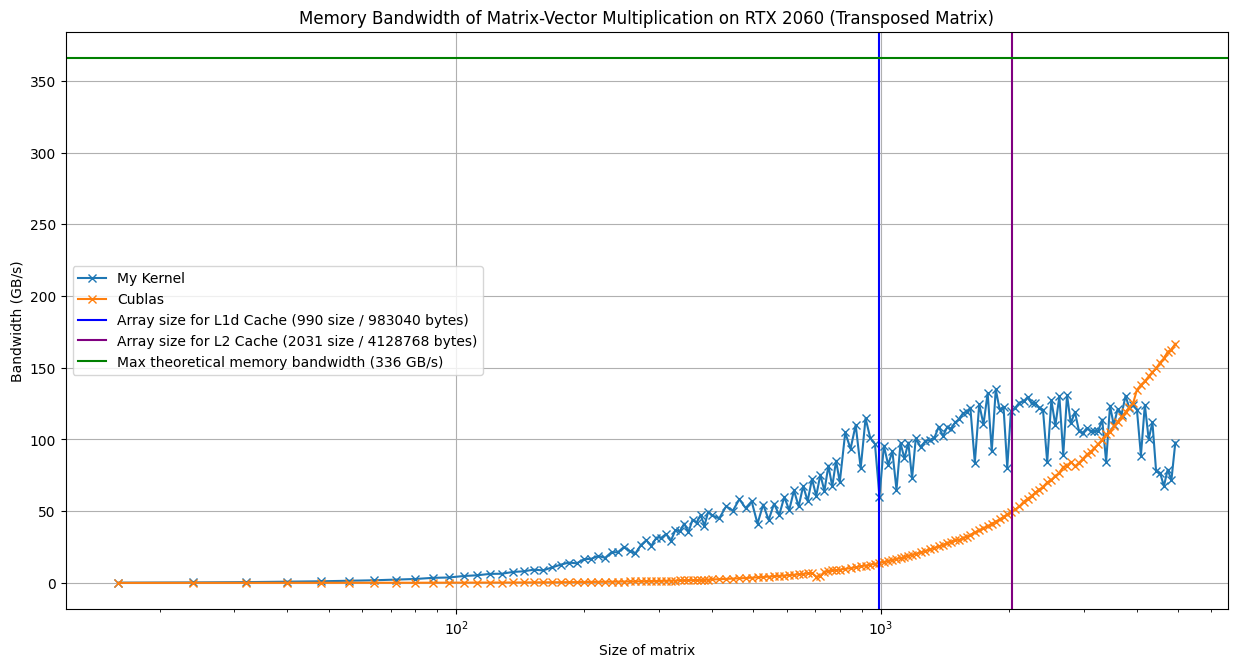

In [40]:
naive1x, naive1y = get_data("data/task3_mykernel.txt", 6, -2)
cublas1x, cublas1y = get_data("data/task3_cublas.txt", 6, -2)

plt.figure(figsize=(15, 7.5))
plt.plot(naive1x, naive1y, "x-", label="My Kernel")
plt.plot(cublas1x, cublas1y, "x-", label="Cublas")
plt.axvline(x=N_L1cache, label=f"Array size for L1d Cache ({N_L1cache} size / {L1cache} bytes)", color="b")
plt.axvline(x=N_L2cache, label=f"Array size for L2 Cache ({N_L2cache} size / {L2cummulative} bytes)", color="purple")
plt.axhline(max_bandwidth, label=f"Max theoretical memory bandwidth (336 GB/s)", color="green")
# plt.axvline(x=l2_size_amd, label=f"L2 Cache ({l2_size_amd} elements)", color="orange")
# plt.axvline(x=l3_size_amd, label=f"L3 Cache ({l3_size_amd} elements)", color="purple")
plt.xlabel("Size of matrix")
plt.ylabel("Bandwidth (GB/s)")
plt.legend()
plt.xscale("log")
plt.grid("both")
plt.title("Memory Bandwidth of Matrix-Vector Multiplication on RTX 2060 (Transposed Matrix)")
plt.show()

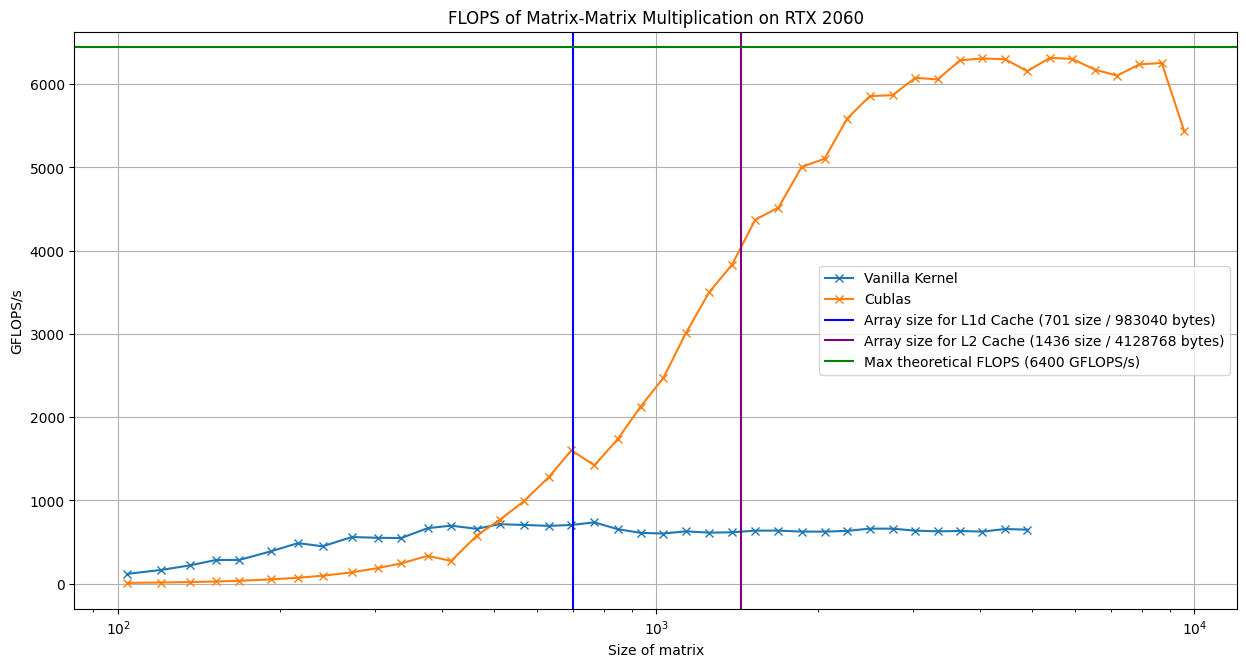

In [51]:
nl1 = int(np.sqrt(L1cache/2))
nl2 = int(np.sqrt(L2cummulative/2))

naive1x, naive1y = get_data("data/task4_naive.txt", 6, -5)
cublas1x, cublas1y = get_data("data/task4_cublas.txt", 6, -5)

plt.figure(figsize=(15, 7.5))
plt.plot(naive1x, naive1y, "x-", label="Vanilla Kernel")
plt.plot(cublas1x, cublas1y, "x-", label="Cublas")
plt.axvline(x=nl1, label=f"Array size for L1d Cache ({nl1} size / {L1cache} bytes)", color="b")
plt.axvline(x=nl2, label=f"Array size for L2 Cache ({nl2} size / {L2cummulative} bytes)", color="purple")
plt.axhline(6450, label=f"Max theoretical FLOPS (6400 GFLOPS/s)", color="green")
# plt.axvline(x=l2_size_amd, label=f"L2 Cache ({l2_size_amd} elements)", color="orange")
# plt.axvline(x=l3_size_amd, label=f"L3 Cache ({l3_size_amd} elements)", color="purple")
plt.xlabel("Size of matrix")
plt.ylabel("GFLOPS/s")
plt.legend()
plt.xscale("log")
plt.grid("both")
plt.title("FLOPS of Matrix-Matrix Multiplication on RTX 2060")
plt.show()